In [1]:
!unzip "/content/asl_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: asl_data/M/User3_M_3.png  
  inflating: __MACOSX/asl_data/M/._User3_M_3.png  
  inflating: asl_data/M/User2_M_6.png  
  inflating: __MACOSX/asl_data/M/._User2_M_6.png  
  inflating: asl_data/M/User4_M_41.png  
  inflating: __MACOSX/asl_data/M/._User4_M_41.png  
  inflating: asl_data/M/User2_M_18.png  
  inflating: __MACOSX/asl_data/M/._User2_M_18.png  
  inflating: asl_data/M/User3_M_18.png  
  inflating: __MACOSX/asl_data/M/._User3_M_18.png  
  inflating: asl_data/M/User3_M_30.png  
  inflating: __MACOSX/asl_data/M/._User3_M_30.png  
  inflating: asl_data/M/User2_M_24.png  
  inflating: __MACOSX/asl_data/M/._User2_M_24.png  
  inflating: asl_data/M/User2_M_30.png  
  inflating: __MACOSX/asl_data/M/._User2_M_30.png  
  inflating: asl_data/M/User3_M_24.png  
  inflating: __MACOSX/asl_data/M/._User3_M_24.png  
  inflating: asl_data/M/User2_M_31.png  
  inflating: __MACOSX/asl_data/M/._User2_M_31.png  
  inflating: asl_data/M

In [2]:
#Defining variables and folder paths
DATA_DIR = "/content/asl_data"         # root containing subfolders per class
IMG_SIZE = (150, 150)
BATCH = 64                    # try 64 first; drop to 32 if memory is tight
EPOCHS = 20
VAL_SPLIT = 0.2               # train/val split from the directory
SEED = 42

In [3]:
# Importing necessary packages and tools
import os, sys, itertools, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import os

bad_files = []

for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        path = os.path.join(root, f)
        # Check empty file
        if os.path.getsize(path) == 0:
            bad_files.append(path)

print("Bad files:", bad_files)
print("Count:", len(bad_files))


Bad files: ['/content/asl_data/O/User1_O_6.png', '/content/asl_data/O/User2_O_4.png', '/content/asl_data/O/User2_O_11.png', '/content/asl_data/O/User1_O_1.png', '/content/asl_data/G/User1_G_6.png', '/content/asl_data/G/User2_G_36.png', '/content/asl_data/G/User2_G_26.png', '/content/asl_data/G/User1_G_48.png', '/content/asl_data/G/User2_G_20.png', '/content/asl_data/G/User1_G_24.png', '/content/asl_data/A/User1_A_21.png', '/content/asl_data/A/User1_A_36.png', '/content/asl_data/A/User2_A_36.png', '/content/asl_data/W/User1_W_33.png', '/content/asl_data/W/User1_W_19.png', '/content/asl_data/X/User1_X_47.png', '/content/asl_data/X/User1_X_7.png', '/content/asl_data/Q/User2_Q_22.png', '/content/asl_data/F/User1_F_43.png', '/content/asl_data/B/User2_B_33.png', '/content/asl_data/B/User1_B_25.png', '/content/asl_data/N/User1_N_5.png', '/content/asl_data/N/User1_N_3.png', '/content/asl_data/N/User1_N_20.png', '/content/asl_data/N/User1_N_36.png', '/content/asl_data/I/User1_I_45.png', '/conte

In [5]:
import os

for path in bad_files:
    try:
        os.remove(path)
        print("Deleted:", path)
    except Exception as e:
        print("Error deleting", path, e)


Deleted: /content/asl_data/O/User1_O_6.png
Deleted: /content/asl_data/O/User2_O_4.png
Deleted: /content/asl_data/O/User2_O_11.png
Deleted: /content/asl_data/O/User1_O_1.png
Deleted: /content/asl_data/G/User1_G_6.png
Deleted: /content/asl_data/G/User2_G_36.png
Deleted: /content/asl_data/G/User2_G_26.png
Deleted: /content/asl_data/G/User1_G_48.png
Deleted: /content/asl_data/G/User2_G_20.png
Deleted: /content/asl_data/G/User1_G_24.png
Deleted: /content/asl_data/A/User1_A_21.png
Deleted: /content/asl_data/A/User1_A_36.png
Deleted: /content/asl_data/A/User2_A_36.png
Deleted: /content/asl_data/W/User1_W_33.png
Deleted: /content/asl_data/W/User1_W_19.png
Deleted: /content/asl_data/X/User1_X_47.png
Deleted: /content/asl_data/X/User1_X_7.png
Deleted: /content/asl_data/Q/User2_Q_22.png
Deleted: /content/asl_data/F/User1_F_43.png
Deleted: /content/asl_data/B/User2_B_33.png
Deleted: /content/asl_data/B/User1_B_25.png
Deleted: /content/asl_data/N/User1_N_5.png
Deleted: /content/asl_data/N/User1_N_3

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 5126 files belonging to 26 classes.
Using 4101 files for training.
Found 5126 files belonging to 26 classes.
Using 1025 files for validation.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'FN', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'SP', 'T', 'U', 'V', 'W', 'X', 'Y']


In [7]:
# Your code here
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import layers, models, regularizers, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 3: Use a Pre-trained Network with Transfer Learning
# Define input shape required by ResNet50V2
input_shape = (224, 224, 3)

# Create base model with pre-trained weights
base_model = ResNet50V2(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape)

# Build the full model with custom top layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(26, activation='softmax')
])

#Resize and preprocess datasets
def preprocess_dataset(ds):
    ds = ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    return ds

train_ds = preprocess_dataset(train_ds)
validation_ds = preprocess_dataset(val_ds)

#Setup callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_resnet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,466 (93.98 MB)

 Trainable params: 24,586,906 (93.79 MB)

 Non-trainable params: 50,560 (197.50 KB)

In [8]:
# Phase 1 code here
print("Phase 1: Training only the top layers with frozen base model...")

base_model.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase1 = model.fit(
    train_ds,
    epochs=15,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Phase 1: Training only the top layers with frozen base model...
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.3843 - loss: 2.9728
Epoch 1: val_accuracy improved from -inf to 0.63024, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 51s 494ms/step - accuracy: 0.3868 - loss: 2.9595 - val_accuracy: 0.6302 - val_loss: 1.6447 - learning_rate: 0.0010
Epoch 2/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8590 - loss: 0.8785
Epoch 2: val_accuracy improved from 0.63024 to 0.84098, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.8593 - loss: 0.8771 - val_accuracy: 0.8410 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 3/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9308 - loss: 0.6223
Epoch 3: val_accuracy improved from 0.84098 to 0.87707, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.9308 - loss: 0.6225 - val_accuracy: 0.8771 - val_loss

In [9]:
# Phase 2 code here
print("\nPhase 2: Fine-tuning the model with small learning rate...")

# Unfreeze the base model, but keep BatchNorm layers frozen
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Compile model for Phase 2 with much smaller learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train Phase 2
history_phase2 = model.fit(
    train_ds,
    epochs=15,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Phase 2: Fine-tuning the model with small learning rate...
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9883 - loss: 0.3479
Epoch 1: val_accuracy improved from 0.94634 to 0.94927, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 89s 818ms/step - accuracy: 0.9883 - loss: 0.3479 - val_accuracy: 0.9493 - val_loss: 0.4660 - learning_rate: 1.0000e-05
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9922 - loss: 0.3381
Epoch 2: val_accuracy improved from 0.94927 to 0.96098, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 540ms/step - accuracy: 0.9922 - loss: 0.3381 - val_accuracy: 0.9610 - val_loss: 0.4177 - learning_rate: 1.0000e-05
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9910 - loss: 0.3379
Epoch 3: val_accuracy improved from 0.96098 to 0.97561, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 582ms/step - accuracy: 0.9910 - loss: 0.3378 - val_accuracy: 0.9756 - v

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - accuracy: 0.9832 - loss: 0.3512
Final validation accuracy: 0.9873
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


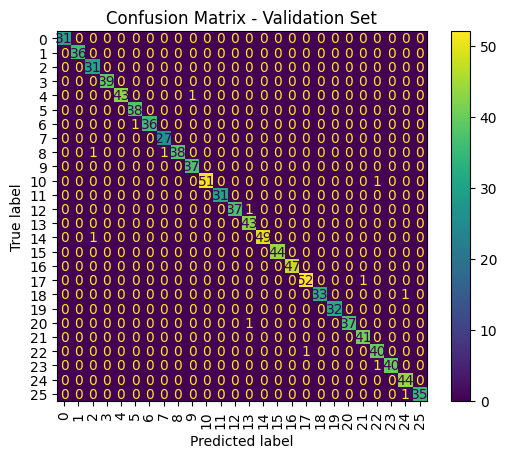

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Load the best model and evaluate
best_model = tf.keras.models.load_model('best_resnet_model.keras')
evaluation = best_model.evaluate(validation_ds)
print(f"Final validation accuracy: {evaluation[1]:.4f}")

# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in validation_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

import pandas as pd

cm_sum = cm.sum(axis=1)
class_accuracy = np.diag(cm) / cm_sum

accuracy_df = pd.DataFrame({'Class': class_names, 'Accuracy': class_accuracy})
print(accuracy_df.sort_values(by='Accuracy'))

Validation Accuracy: 0.9873
   Class  Accuracy
8      H  0.950000
18     S  0.970588
25     Y  0.972222
6     FN  0.972973
12     M  0.973684
20     T  0.973684
22     V  0.975610
23     W  0.975610
4      E  0.977273
14     O  0.980000
10     K  0.980769
17     R  0.981132
7      G  1.000000
5      F  1.000000
0      A  1.000000
1      B  1.000000
15     P  1.000000
13     N  1.000000
9      I  1.000000
11     L  1.000000
3      D  1.000000
2      C  1.000000
19    SP  1.000000
16     Q  1.000000
21     U  1.000000
24     X  1.000000


In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),     # for ASL: keep if your dataset is not direction-sensitive; otherwise remove
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomBrightness(factor=0.1),
])

In [7]:
def make_model(input_shape=(150,150,3), num_classes=18, dropout=0.4):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    x = conv_block(x, 32)
    x = layers.MaxPooling2D()(x)

    x = conv_block(x, 64)
    x = layers.MaxPooling2D()(x)

    x = conv_block(x, 128)
    x = layers.MaxPooling2D()(x)

    x = conv_block(x, 256)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="asl_cnn")

model = make_model(input_shape=IMG_SIZE + (3,), num_classes=num_classes)

# Optimizer & compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


NameError: name 'data_augmentation' is not defined

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint("asl_cnn_best.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_loss")
]

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_6828]

In [ ]:
eval_res = model.evaluate(val_ds, verbose=0)
print(f"Validation — loss: {eval_res[0]:.4f}  acc: {eval_res[1]:.4f}")

In [ ]:
try:
    from sklearn.metrics import confusion_matrix, classification_report
    y_true, y_pred = [], []
    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, target_names=class_names))
    # simple text cm
    print("\nConfusion matrix (rows=true, cols=pred):\n", cm)
except Exception as e:
    print("Install scikit-learn for confusion matrix: pip install scikit-learn")
    print("Skipped confusion matrix.", e)

In [ ]:
model.save("asl_cnn_final.keras")
print("Saved model to asl_cnn_final.keras")